In [1]:
import tclab
from tclab import Plotter, clock, Historian

import numpy as np
import tbcontrol
from tbcontrol import blocksim

import matplotlib.pyplot as plt
from matplotlib import rc

import pandas as pd

import sympy
s = sympy.Symbol('s')

import pathlib

import itertools

%matplotlib inline

import control

G = Gplus*Gminus \
Gplus contains time delays and RHP zeros \

Gplus steady state gain = 1

G_imc = 1/Gminus * F

F is low pass filter 1/(tauC s +1)**r

Base model Transfer Function:
FOPDT \
G_m = K * e**-theta s /(tau*s + 1)

In [3]:
def trimmer(value, upper = 100, lower = 0):
    if value>upper:
        return upper
    elif value<lower:
        return lower
    else:
        return value

In [4]:
def noise_function(size):
    return (np.random.randn()*size)

In [5]:
K = 0.6423
tau = 150.312
theta = 17.397

In [6]:
s = control.TransferFunction.s
# s


s
-
1

In [7]:
model_tf = K/(tau*s +1) #PLUS DEADTIME

In [8]:
#Guide 1
# print ('>',theta*0.8, '& >', 0.1*tau)
#Guide 2
# print (tau,' > tau_c >', theta)
#Guide 3
# print ("= ", theta)

> 13.9176 & > 15.031200000000002
150.312  > tau_c > 17.397
=  17.397


In [9]:
tau_c = theta

In [10]:
# G_plus = (np.exp**(-theta*s))

In [11]:
r = 1

F = 1/(tau_c*s + 1)**r

In [12]:
G_minus = model_tf

In [13]:
IMC_tf = (1/G_minus) * F

In [14]:
run_time = 1200
bias = 0
bias_T = 20
noise = 1
sample_rate = 1

In [15]:
def set_point(t, pair = [500, 50]):
    if t>=500:
        return 50
    else:
        return 35

In [16]:
def disturbance(t, pair = [0, 0]):
    T, val = pair
    if t<T:
        return 0
    else:
        return val

In [17]:
def run(noise, sample_rate, run_time, disturbance_pair = [0, 0]):
    """
    disturbance pair takes an iterable of time at which to start disturbance, and value of Q2 to disturb to
    """
    
    # simulate zero-error run to get initial state vector
    T, yout, xout = control.forced_response(IMC_tf, [0, 1], None, transpose=True)
    # get initial state vector
    xcc = xout[-1]

    Tm, ymout, xmout = control.forced_response(model_tf, [0, 1], None, transpose=True)
    xcm = xmout[-1]

    model_predictions = []
    errors = []
    controller_outputs = list(np.zeros(int(theta*10)))
    noisy_values = []
    
    

    with tclab.TCLabModel(synced=False) as lab:
        sources = lab.sources
        h = tclab.Historian(sources)

        prev_t = -1

        error = set_point(0) - lab.T1

        for t in np.arange(0,run_time,sample_rate):#clock(run_time):  # change to tclab.clock(steptime=steptime) to sync with time
            # Figure out how much time has gone by since previous clock tick
            # Note in the simulation case this will always be `steptime`, but when we sync
            # it may not be, so we have to calculate correctly
            Δt = t - prev_t
            prev_t = t
    #         print(-int(theta/Δt)-1)

            # integrate controller assuming error stays constant over timestep (zero-order-hold)
            # notice we're using the error from the previous time step, 
            # because we're simulating from one step ago to right now.
            _, yout, xout = control.forced_response(IMC_tf, [0, Δt], [error, error], xcc, transpose=True)

            controller_output = yout[-1] + bias
            controller_outputs.append(trimmer(controller_output))
            xcc = xout[-1]


            # predict model
            _, ymout, xmout = control.forced_response(model_tf, [0, Δt], [controller_outputs[-int(theta/Δt)-1], controller_outputs[-int(theta/Δt)]], xcm, transpose=True)
            model_output = (ymout[-1])

            model_predictions.append(model_output + bias_T)
            xcm = xmout[-1]

            # communicate with tclab
            # We read the error at "the same time" as we write
            # This ensures that the controller uses only information from the previous time step
            measured_value = lab.T1 + noise_function(noise)
            noisy_values.append(measured_value)

            error = set_point(t) - (measured_value - model_output)
            errors.append(error)

            # write out to tclab
    #         lab.Q2(disturbance(t))
            lab.Q1(controller_output)

            # update historian
            h.update(t)
            lab.update(t)  # for the real lab this is not required
            
            lab.Q2(disturbance(t, disturbance_pair))
        return (model_predictions, errors, controller_outputs, noisy_values, h.logdict['T1'], h.t, h.logdict['T2'])

In [18]:
rc("text", usetex=False)
rc("font", family="serif")

# These figure sizes should correspond with the size in the LaTeX document.
# don't change the font size to compensate for scaling the figure down
aspect_ratio = 4 / 5
FULLSIZE = 5, 5 * aspect_ratio
HALFSIZE = 3, 3 * aspect_ratio

## Noise Variation with cosntant Sampling rate

In [19]:
noise_factors = [0, 1, 5, 10]
noise_factors.reverse()
sampling_rates = [1]

In [20]:
run_time = 1200

In [21]:
noisy_values_collected = []
controller_outputs_collected = []
times_collected = []
noise_sample = []
true_values_collected = []

for noise, sample_rate in itertools.product(noise_factors, sampling_rates):
    noise_sample.append([noise, sample_rate])
    model_predictions, errors, controller_outputs, noisy_values, true_values, times, _ = run(noise, sample_rate, run_time)
    
    noisy_values_collected.append(noisy_values)
    controller_outputs_collected.append(controller_outputs[len(list(np.zeros(int(theta*10)))):])
    times_collected.append(times)
    true_values_collected.append(true_values)
    

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


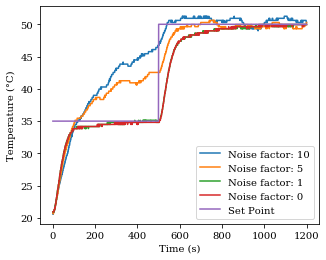

In [22]:
plt.figure(figsize = FULLSIZE)
for values, pair, times in zip(true_values_collected, noise_sample, times_collected):
    plt.plot(times, values,label = 'Noise factor: ' + str(pair[0]))

plt.plot(times, list(set_point(x) for x in times), label = "Set Point")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (\u00b0C)')
plt.savefig(pathlib.Path('PDFS').expanduser()/pathlib.Path('IMC effect of noise on steady state temp.pdf'))

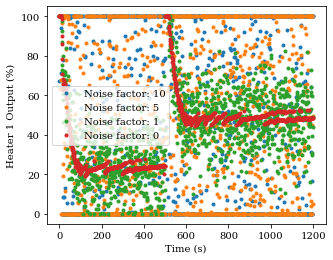

In [23]:
plt.figure(figsize = FULLSIZE)
for values, pair, times in zip(controller_outputs_collected, noise_sample, times_collected):
    plt.plot(times, values, '.', label = 'Noise factor: ' + str(pair[0]))
    
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heater 1 Output (%)')
plt.savefig(pathlib.Path('PDFS').expanduser()/pathlib.Path('IMC effect of noise on controller output.pdf'))

## Sampling rate Variation with constant Noise

In [24]:
noise_factors = [0]
noise_factors.reverse()
sampling_rates = [0.1, 1, 2, 10]

In [25]:
run_time = 1200

In [26]:
noisy_values_collected = []
controller_outputs_collected = []
times_collected = []
noise_sample = []
true_values_collected = []

for noise, sample_rate in itertools.product(noise_factors, sampling_rates):
    noise_sample.append([noise, sample_rate])
    model_predictions, errors, controller_outputs, noisy_values, true_values, times, _ = run(noise, sample_rate, run_time)
    
    noisy_values_collected.append(noisy_values)
    controller_outputs_collected.append(controller_outputs[len(list(np.zeros(int(theta*10)))):])
    times_collected.append(times)
    true_values_collected.append(true_values)
    

TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


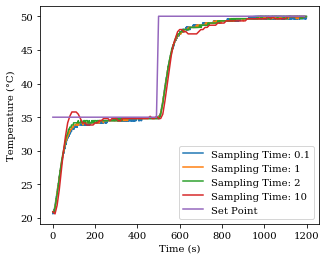

In [27]:
plt.figure(figsize = FULLSIZE)
for values, pair, times in zip(true_values_collected, noise_sample, times_collected):
    plt.plot(times, values, label = 'Sampling Time: ' + str(pair[1]))

plt.plot(times, list(set_point(x) for x in times), label = "Set Point")
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Temperature (\u00b0C)')
plt.savefig(pathlib.Path('PDFS').expanduser()/pathlib.Path('IMC effect of Sampling Rate on steady state temp.pdf'))

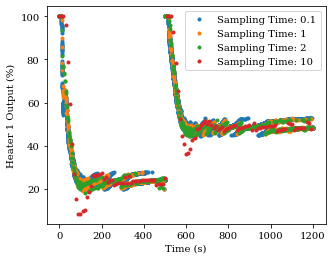

In [28]:
plt.figure(figsize = FULLSIZE)
for values, pair, times in zip(controller_outputs_collected, noise_sample, times_collected):
    plt.plot(times, values, '.', label = 'Sampling Time: ' + str(pair[1]))
    
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Heater 1 Output (%)')
plt.savefig(pathlib.Path('PDFS').expanduser()/pathlib.Path('IMC effect of Sampling Rate on controller output.pdf'))

## Noise and Sampling Rate Variation

In [29]:
noise_factors = [0, 0.5, 1, 5, 10]
sampling_rates = [0.1, 1, 20]

In [30]:
run_time = 1200

0 0.1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
0 1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
0 20
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
0.5 0.1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
0.5 1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
0.5 20
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
1 0.1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
1 1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
1 20
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
5 0.1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
5 1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
5 20
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.
10 0.1
TCLab version 0.4.9
Simulat

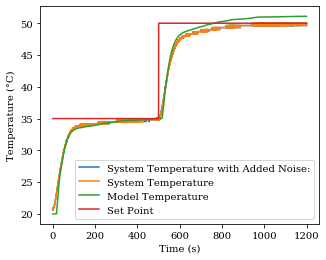

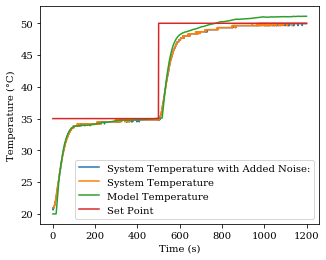

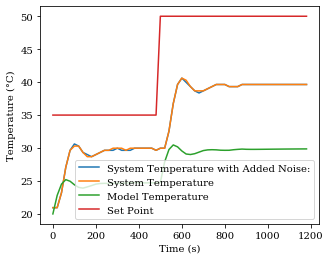

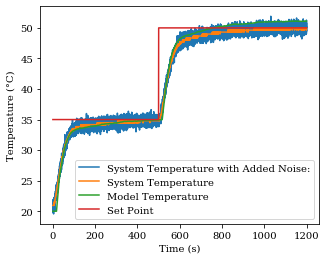

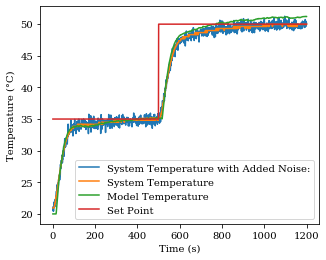

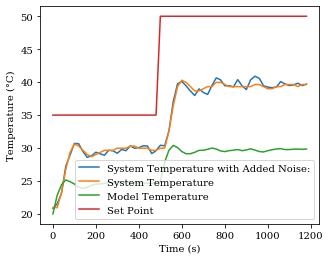

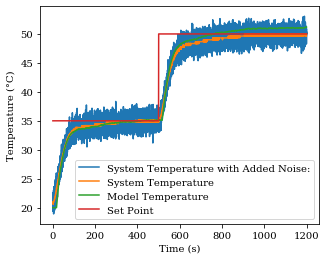

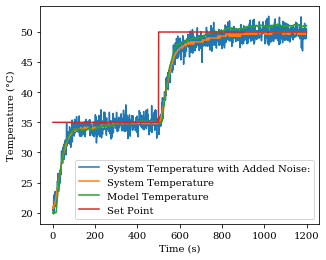

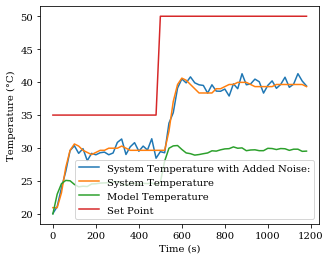

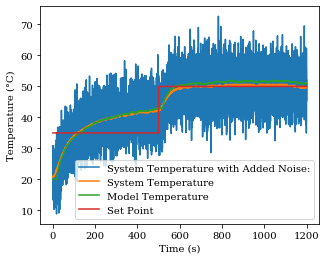

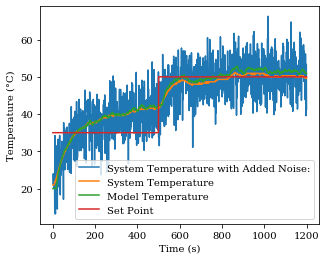

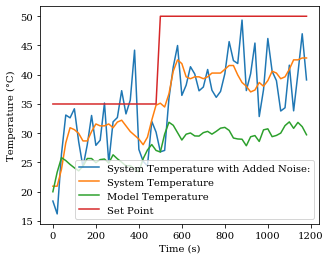

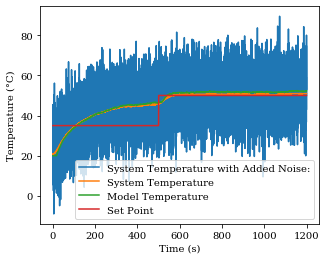

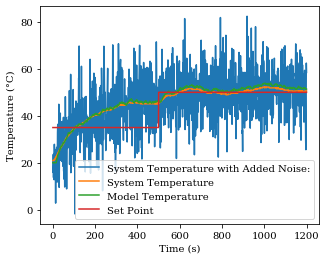

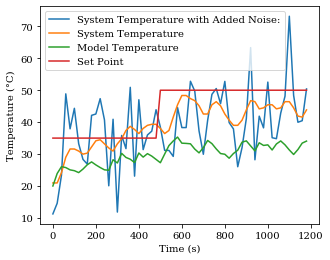

In [31]:
noisy_values_collected = []
controller_outputs_collected = []
times_collected = []
noise_sample = []
true_values_collected = []

for noise, sample_rate in itertools.product(noise_factors, sampling_rates):
    print (noise, sample_rate)
    noise_sample.append([noise, sample_rate])
    model_predictions, errors, controller_outputs, noisy_values, true_values, times, _ = run(noise, sample_rate, run_time)
    
    noisy_values_collected.append(noisy_values)
    controller_outputs_collected.append(controller_outputs[len(list(np.zeros(int(theta*10)))):])
    times_collected.append(times)
    true_values_collected.append(true_values)
    

    plt.figure(figsize = FULLSIZE)
    
#     plt.title('System with a sampling time of ' + str(sample_rate) + 's and a noise factor of ' + str(noise))

    plt.plot(times, noisy_values, label = "System Temperature with Added Noise:")
    plt.plot(times, true_values, label = "System Temperature")
    plt.plot(times, model_predictions, label = "Model Temperature")

    plt.plot(times, list(set_point(x) for x in times), label = "Set Point")

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (\u00b0C)')

    plt.savefig(pathlib.Path('PDFS').expanduser()/pathlib.Path('IMC With ' + str(noise) + ' noise, and ' + str(sample_rate) + 's sample rate.pdf'))

## Run for Matthew

In [32]:
noise_factors = [0]
sampling_rates = [1]

0 1
TCLab version 0.4.9
Simulated TCLab
TCLab Model disconnected successfully.


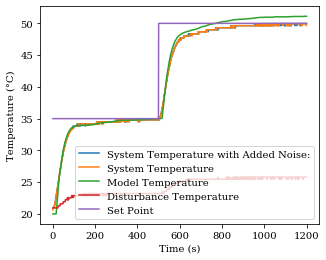

In [38]:
noisy_values_collected = []
controller_outputs_collected = []
times_collected = []
noise_sample = []
true_values_collected = []
T2_values_collected = []

for noise, sample_rate in itertools.product(noise_factors, sampling_rates):
    print (noise, sample_rate)
    noise_sample.append([noise, sample_rate])
    model_predictions, errors, controller_outputs, noisy_values, true_values, times, T2_values = run(noise, sample_rate, run_time, )
    
    noisy_values_collected.append(noisy_values)
    controller_outputs_collected.append(controller_outputs[len(list(np.zeros(int(theta*10)))):])
    times_collected.append(times)
    true_values_collected.append(true_values)
    T2_values_collected.append(T2_values)
    

    plt.figure(figsize = FULLSIZE)
    
#     plt.title('System with a sampling time of ' + str(sample_rate) + 's and a noise factor of ' + str(noise))

    plt.plot(times, noisy_values, label = "System Temperature with Added Noise:")
    plt.plot(times, true_values, label = "System Temperature")
    plt.plot(times, model_predictions, label = "Model Temperature")
    plt.plot(times, T2_values, label = "Disturbance Temperature")

    plt.plot(times, list(set_point(x) for x in times), label = "Set Point")

    plt.legend()
    plt.xlabel('Time (s)')
    plt.ylabel('Temperature (\u00b0C)')

    plt.savefig(pathlib.Path('PDFS').expanduser()/pathlib.Path('IMC With ' + str(noise) + ' noise, and ' + str(sample_rate) + 's sample rate and disturbance.pdf'))
    
data_frame = pd.DataFrame(data = (times_collected, true_values_collected, T2_values_collected, controller_outputs_collected))
data_frame.to_csv(pathlib.Path('CSVS').expanduser()/pathlib.Path('cont_IMC.csv'))